#TASK 2: Graph Surgeon

#1. Creating An ONNX Graph Model - GlobalLpPool layer.

**TREE STRUCTURE:**
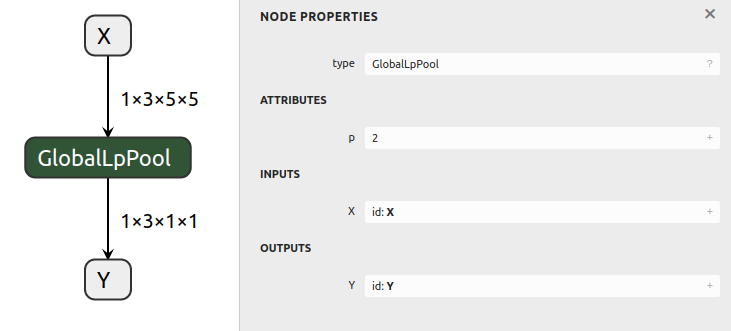

In [ ]:
!pip install onnx
!pip install onnx-graphsurgeon
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
# importing dependencies
import onnx
import onnx_graphsurgeon as gs
import numpy as np

# Defining Input and Output Tensors
X = gs.Variable(name="X", dtype=np.float32, shape=(1, 3, 5, 5))  # Input Tensor
Y = gs.Variable(name="Y", dtype=np.float32, shape=(1, 3, 1, 1))  # Output Tensor

# Defining the GlobalLpPool Node
global_lp_pool_node = gs.Node(
    op="GlobalLpPool",  # ONNX Operator
    inputs=[X],
    outputs=[Y],
    attrs={"p": 2}
)

# Create an ONNX Graph with one node
graph = gs.Graph(nodes=[global_lp_pool_node], inputs=[X], outputs=[Y])

# Step 4: Export the Graph to ONNX Format
onnx_model = gs.export_onnx(graph)
onnx.save(onnx_model, "test_globallppool.onnx")

print("ONNX model 'test_globallppool.onnx' generated successfully!")

ONNX model 'test_globallppool.onnx' generated successfully!


In [ ]:
model = onnx.load("test_globallppool.onnx")
onnx.checker.check_model(model)
print(onnx.helper.printable_graph(model.graph))

graph onnx_graphsurgeon_graph (
  %X[FLOAT, 1x3x5x5]
) {
  %Y = GlobalLpPool[p = 2](%X)
  return %Y
}


Using the model

In [ ]:
import onnxruntime as ort

# Load the model
session = ort.InferenceSession("test_globallppool.onnx")

# Prepare input data
input_data = np.random.rand(1, 3, 5, 5).astype(np.float32)

# Run inference
output = session.run(None, {"X": input_data})

print("Output Shape:", output[0].shape)  # Expected: (1, 3, 1, 1)

Output Shape: (1, 3, 1, 1)


#2.Creating An ONNX Model With An Initializer - Convolution Layer

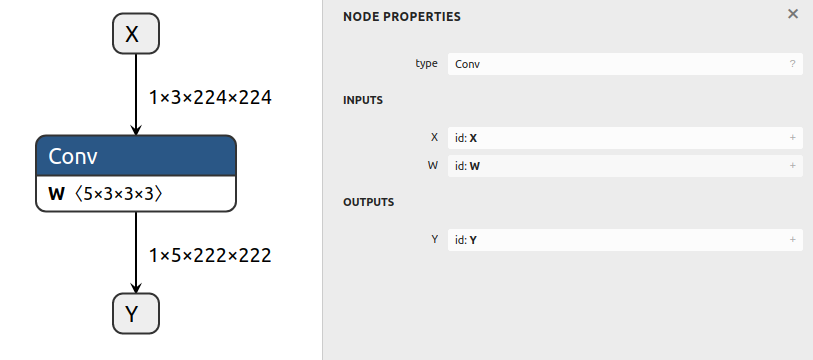

In [ ]:
X = gs.Variable(name="X", dtype=np.float32, shape=(1, 3, 224, 224)) # (batch_size, filters, input_size)

# Since W is a Constant, it will automatically be exported as an initializer - (filters, channels, kernel size)
W = gs.Constant(name="W", values=np.ones(shape=(5, 3, 3, 3), dtype=np.float32))

Y = gs.Variable(name="Y", dtype=np.float32, shape=(1, 5, 222, 222))

node = gs.Node(op="Conv", inputs=[X, W], outputs=[Y])

# Note that initializers do not necessarily have to be graph inputs
graph = gs.Graph(nodes=[node], inputs=[X], outputs=[Y])
onnx.save(gs.export_onnx(graph), "test_conv.onnx")
print("ONNX model 'test_conv.onnx' generated successfully!")

ONNX model 'test_conv.onnx' generated successfully!


#3. Isolating A Subgraph

Graph with many nodes: The generated model computes Y = x0 + (a * x1 + b)

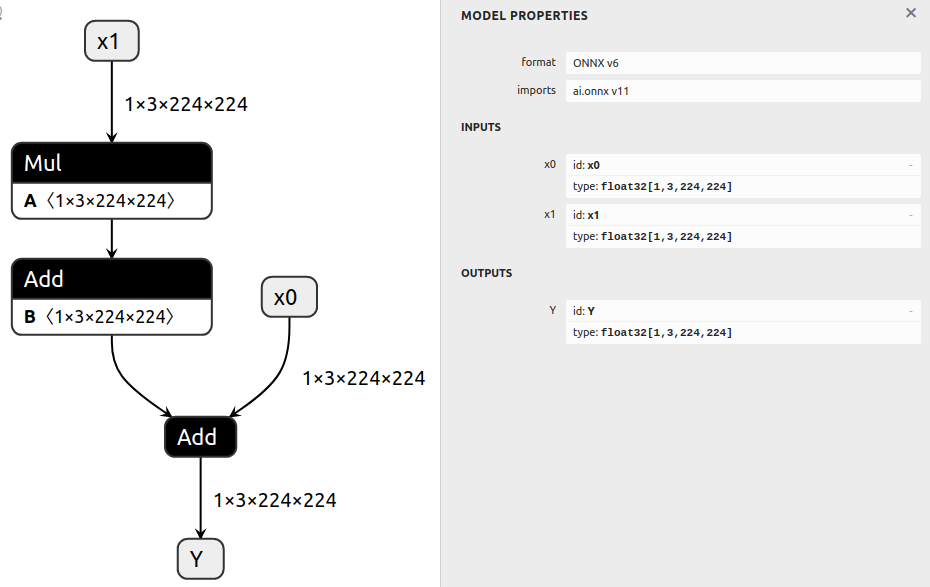

Isolated subgraph: The resulting model computes add_out = (a * x1 + b)

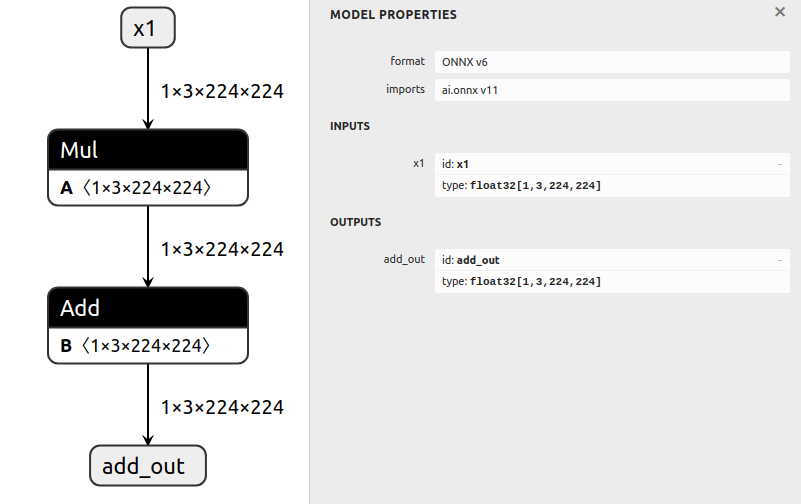


In [ ]:
# Graph with many nodes : x0 + (a * x1 + b)

input_shape = (1, 3, 224, 224)

# Inputs
x0 = gs.Variable(name="x0", dtype=np.float32, shape=input_shape)
x1 = gs.Variable(name="x1", dtype=np.float32, shape=input_shape)

# Intermediate tensors
a = gs.Constant("a", values=np.ones(shape=input_shape, dtype=np.float32))
b = gs.Constant("b", values=np.ones(shape=input_shape, dtype=np.float32))
mul_out = gs.Variable(name="mul_out")
add_out = gs.Variable(name="add_out")

# Outputs
Y = gs.Variable(name="Y", dtype=np.float32, shape=input_shape)

nodes = [
    # mul_out = a * x1
    gs.Node(op="Mul", inputs=[a, x1], outputs=[mul_out]),
    # add_out = mul_out + b
    gs.Node(op="Add", inputs=[mul_out, b], outputs=[add_out]),
    # Y = x0 + add
    gs.Node(op="Add", inputs=[x0, add_out], outputs=[Y]),
]

graph = gs.Graph(nodes=nodes, inputs=[x0, x1], outputs=[Y])
onnx.save(gs.export_onnx(graph), "model.onnx")
print("ONNX model 'model.onnx' generated successfully!")

ONNX model 'model.onnx' generated successfully!


In [ ]:
# Isolated Graph: (a * x1 + b)

model = onnx.load("model.onnx")
graph = gs.import_onnx(model)

tensors = graph.tensors() # ordered dict

for i in tensors:
    print(i, tensors[i])

"""
to_variable(): What It Does
    -> If the tensor is a constant, it converts it into a variable (so it can be set at runtime).
    -> If the tensor is already a variable, it ensures it stays as a variable.
    -> It also allows setting or overriding the data type (dtype).
"""
graph.inputs = [tensors["x1"].to_variable(dtype=np.float32)]
graph.outputs = [tensors["add_out"].to_variable(dtype=np.float32)]

graph.cleanup()

onnx.save(gs.export_onnx(graph), "subgraph.onnx")
print("\nONNX model 'subgraph.onnx' generated successfully!")

x0 Variable (x0): (shape=[1, 3, 224, 224], dtype=float32)
x1 Variable (x1): (shape=[1, 3, 224, 224], dtype=float32)
a Constant (a): (shape=[1, 3, 224, 224], dtype=float32)
mul_out Variable (mul_out): (shape=None, dtype=None)
b Constant (b): (shape=[1, 3, 224, 224], dtype=float32)
add_out Variable (add_out): (shape=None, dtype=None)
Y Variable (Y): (shape=[1, 3, 224, 224], dtype=float32)

ONNX model 'subgraph.onnx' generated successfully!


#4. Modiyfing A Model

MODIFICATIONS PERFORMED:
1.   Removed the b input of the first Add node
2.   Changed the first Add to a LeakyRelu
4.   Changed the output of the graph to be the output of the Identity node
5.   Runs cleanup() which removes the x0 tensor and second Add node due to the previous change to the graph outputs.

**INITIAL MODEL:**

Same as model.onnx

**MODEL WITH MODIFICATION:**

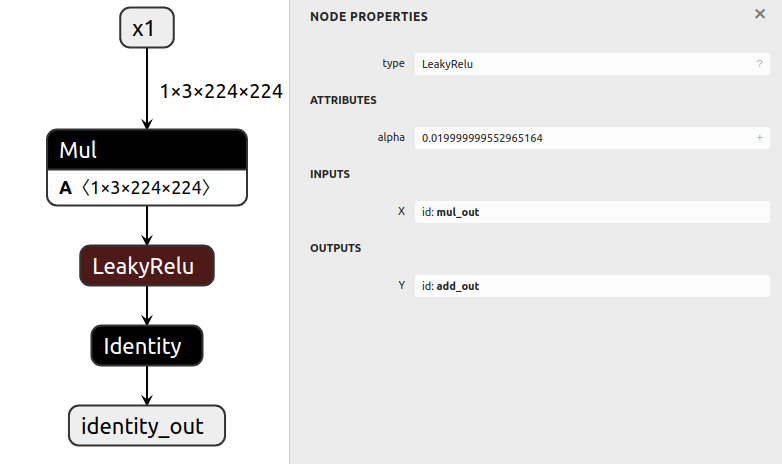

In [ ]:
graph = gs.import_onnx(onnx.load("model.onnx"))
print("Nodes of the ONNX Graph: \n\n", graph.nodes)

# 1. Remove the `b` input of the add node
first_add = [node for node in graph.nodes if node.op == "Add"][0]
print("\n\n\n\nAdd with b parameter as input: \n\n", first_add)

first_add.inputs = [inp for inp in first_add.inputs if inp.name != "b"]
print("\n\n\n\nAdd without b parameter as input: \n\n", first_add)

# 2. Change the Add to a LeakyRelu
first_add.op = "LeakyRelu"
first_add.attrs["alpha"] = 0.02

# 3. Add an identity after the add node
identity_out = gs.Variable("identity_out", dtype=np.float32)

identity = gs.Node(op="Identity", inputs=first_add.outputs, outputs=[identity_out])
graph.nodes.append(identity)

# 4. Modify the graph output to be the identity output
graph.outputs = [identity_out]

# 5. Remove unused nodes/tensors, and topologically sort the graph
graph.cleanup(remove_unused_graph_inputs=True).toposort()

model = onnx.shape_inference.infer_shapes(gs.export_onnx(graph))
onnx.save(model, "modified.onnx")
print("\n\n\n\nONNX model 'modified.onnx' generated successfully!")

Nodes of the ONNX Graph: 

 [ (Mul)
	Inputs: [
		Constant (a): (shape=[1, 3, 224, 224], dtype=float32)
		Variable (x1): (shape=[1, 3, 224, 224], dtype=float32)
	]
	Outputs: [
		Variable (mul_out): (shape=None, dtype=None)
	],  (Add)
	Inputs: [
		Variable (mul_out): (shape=None, dtype=None)
		Constant (b): (shape=[1, 3, 224, 224], dtype=float32)
	]
	Outputs: [
		Variable (add_out): (shape=None, dtype=None)
	],  (Add)
	Inputs: [
		Variable (x0): (shape=[1, 3, 224, 224], dtype=float32)
		Variable (add_out): (shape=None, dtype=None)
	]
	Outputs: [
		Variable (Y): (shape=[1, 3, 224, 224], dtype=float32)
	]]




Add with b parameter as input: 

  (Add)
	Inputs: [
		Variable (mul_out): (shape=None, dtype=None)
		Constant (b): (shape=[1, 3, 224, 224], dtype=float32)
	]
	Outputs: [
		Variable (add_out): (shape=None, dtype=None)
	]




Add without b parameter as input: 

  (Add)
	Inputs: [
		Variable (mul_out): (shape=None, dtype=None)
	]
	Outputs: [
		Variable (add_out): (shape=None, dtype=None

#5. Folding Constants

**INITIAL ONNX TREE:** output = input + ((a + b) + d) where a,b, and d are constants


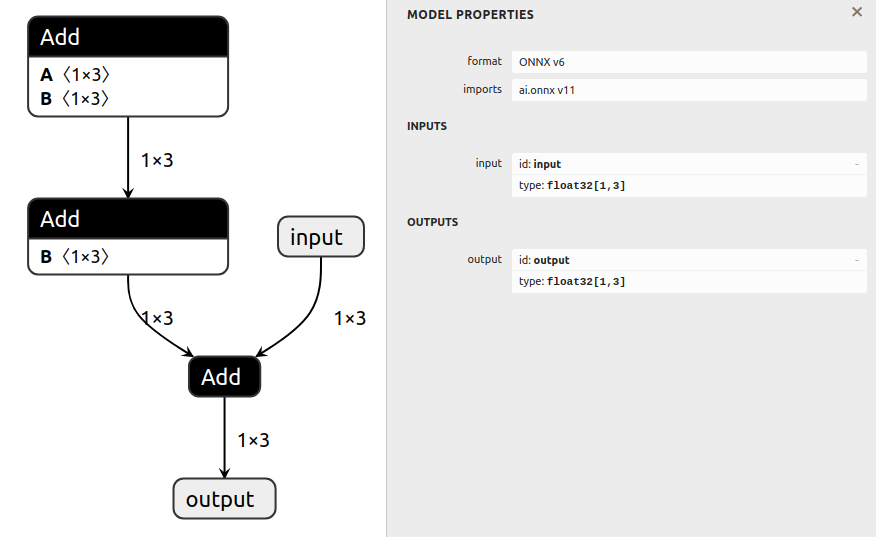

**ONNX TREE AFTER CONSTANT FOLDING:**output = input + e where e = ((a + b) + d)


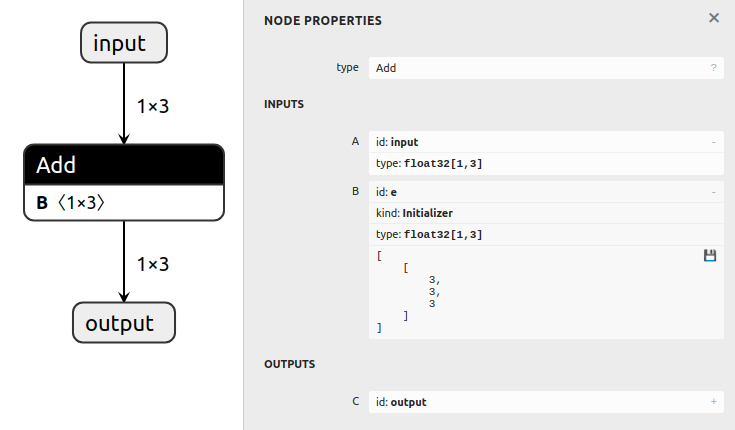


In [ ]:
# Tree without folding
input_shape = (1, 3)

# Inputs
input = gs.Variable("input", shape=input_shape, dtype=np.float32)

# Intermediate tensors
a = gs.Constant("a", values=np.ones(shape=input_shape, dtype=np.float32))
b = gs.Constant("b", values=np.ones(shape=input_shape, dtype=np.float32))
c = gs.Variable("c")
d = gs.Constant("d", values=np.ones(shape=input_shape, dtype=np.float32))
e = gs.Variable("e")

# Outputs
output = gs.Variable("output", shape=input_shape, dtype=np.float32)

nodes = [
    # c = (a + b)
    gs.Node("Add", inputs=[a, b], outputs=[c]),
    # e = (c + d)
    gs.Node("Add", inputs=[c, d], outputs=[e]),
    # output = input + e
    gs.Node("Add", inputs=[input, e], outputs=[output]),
]

graph = gs.Graph(nodes=nodes, inputs=[input], outputs=[output])
onnx.save(gs.export_onnx(graph), "model.onnx")
print("\nONNX model 'model.onnx' generated successfully!")


ONNX model 'model.onnx' generated successfully!


In [ ]:
graph = gs.import_onnx(onnx.load("model.onnx"))

graph.fold_constants().cleanup()

onnx.save(gs.export_onnx(graph), "folded.onnx")
print("\nONNX model 'folded.onnx' generated successfully!")


ONNX model 'folded.onnx' generated successfully!


# 6.Removing A Node

**INITIAL GRAPH**:


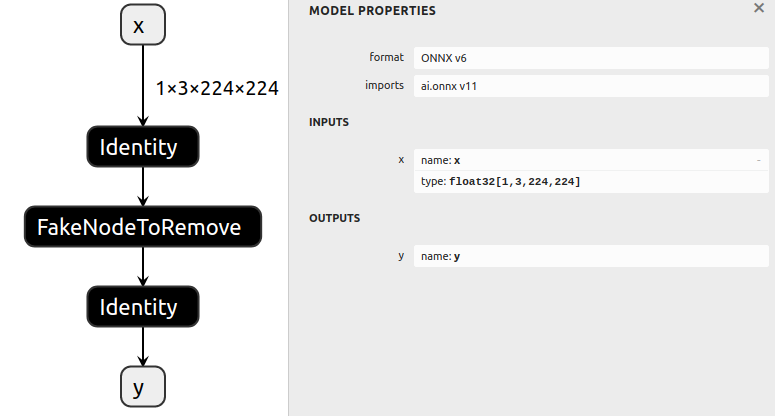

**GRAPH AFTER REMOVAL**:

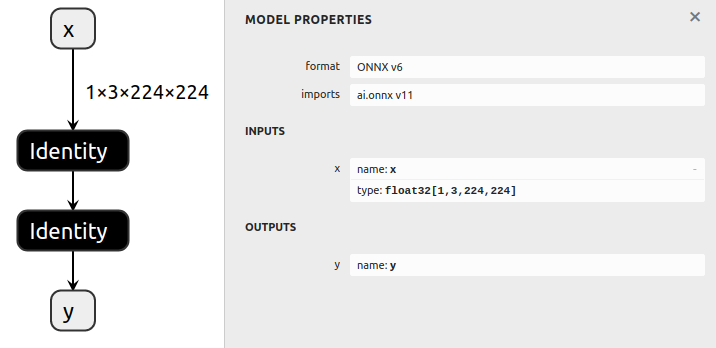

In [ ]:
# Initial Graph
x = gs.Variable(name="x", dtype=np.float32, shape=(1, 3, 224, 224))

# Intermediate tensors
i0 = gs.Variable(name="i0")
i1 = gs.Variable(name="i1")

# Outputs
y = gs.Variable(name="y", dtype=np.float32)

nodes = [
    gs.Node(op="Identity", inputs=[x], outputs=[i0]),
    gs.Node(op="FakeNodeToRemove", inputs=[i0], outputs=[i1]),
    gs.Node(op="Identity", inputs=[i1], outputs=[y]),
]

graph = gs.Graph(nodes=nodes, inputs=[x], outputs=[y])

"""
Shape inference:
    -> Since the fake node does not exist in ONNX’s standard ops, it might cause shape inconsistencies.
    -> After modifying the graph (like removing the node), shape inference ensures correctness
"""
model = onnx.shape_inference.infer_shapes(gs.export_onnx(graph))

onnx.save(model, "model.onnx")
print("ONNX model 'model.onnx' generated successfully!")

ONNX model 'model.onnx' generated successfully!


**Difference between fake_node.i() and fake_node.input:**

**fake_node.inputs:**

-> This is a list of input tensors that fake_node receives.

`Eg: fake_node.inputs => [i0]`


**fake_node.i():**


-> This returns the actual node that produces fake_node's first input.

`Eg: fake_node.i() => Identity`

In [ ]:
# Removing FakeNodeToRemove Node

graph = gs.import_onnx(onnx.load("model.onnx"))

fake_node = [node for node in graph.nodes if node.op == "FakeNodeToRemove"][0]

# fake_node.i() retrieves the input node feeding into fake_node
inp_node = fake_node.i()

inp_node.outputs = fake_node.outputs
fake_node.outputs.clear()

# Remove the fake node from the graph completely
graph.cleanup()

model = onnx.shape_inference.infer_shapes(gs.export_onnx(graph))
onnx.save(model, "removed.onnx")
print("ONNX model 'removed.onnx' generated successfully!")

ONNX model 'removed.onnx' generated successfully!


# 7. Creating A Model Using The Graph Layer API

The mathematical equation being implemented is:

output = ReLU( (𝐴 ⋅ 𝑋^𝑇) + 𝐵 ) ⋅ 𝐶 + 𝐷


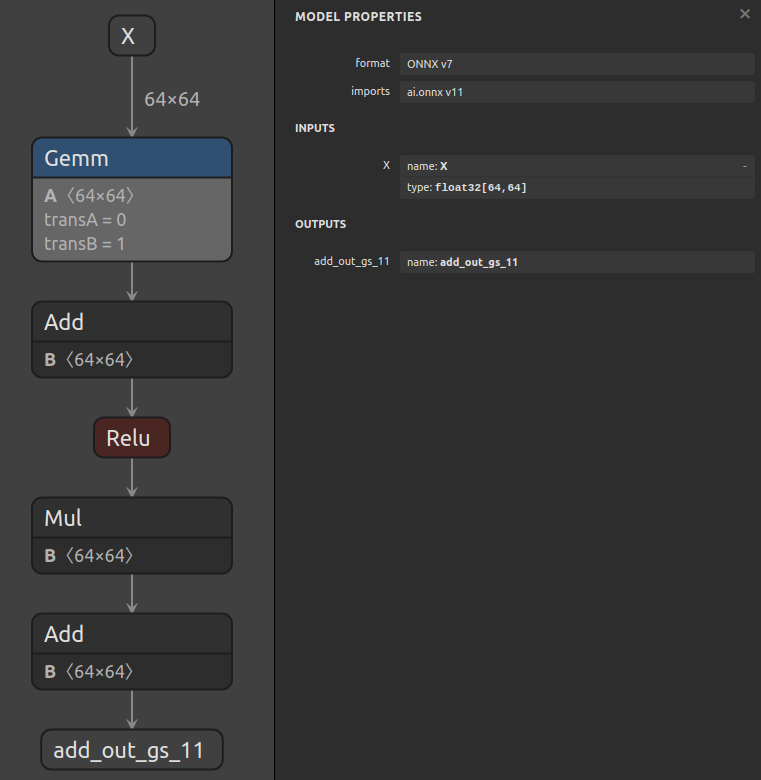

In [ ]:
"""
    The output names don’t overlap because ONNX GraphSurgeon automatically appends an index to ensure uniqueness
    when the same function is called multiple times.

    Eg: First call → output name becomes "add_out_gs_0"
        Second call → output name becomes "add_out_gs_1"
"""

@gs.Graph.register()
def add(self, a, b):
    return self.layer(op="Add", inputs=[a, b], outputs=["add_out_gs"])

@gs.Graph.register()
def mul(self, a, b):
    return self.layer(op="Mul", inputs=[a, b], outputs=["mul_out_gs"])

@gs.Graph.register()
def gemm(self, a, b, trans_a=False, trans_b=False):
    attrs = {"transA": int(trans_a), "transB": int(trans_b)}
    return self.layer(op="Gemm", inputs=[a, b], outputs=["gemm_out_gs"], attrs=attrs)

"""
    -> You can also specify a set of opsets when registering a function.
    -> By default, the function is registered for all opsets lower than Graph.DEFAULT_OPSET
"""

@gs.Graph.register(opsets=[11])
def relu(self, a):
    return self.layer(op="Relu", inputs=[a], outputs=["act_out_gs"])

"""
    -> Note that the same function can be defined in different ways for different opsets.
    -> It will only be called if the Graph's opset matches one of the opsets for which the function is registered.
    -> Hence, for the opset 11 graph used in this example, the following function will never be used.
"""
@gs.Graph.register(opsets=[1])
def relu(self, a):
    raise NotImplementedError("This function has not been implemented!")

graph = gs.Graph(opset=11)

# Generates a graph which computes ReLU((A * X^T) + B) . C + D
X = gs.Variable(name="X", shape=(64, 64), dtype=np.float32)
graph.inputs = [X]

# axt = (A * X^T)
# Note that here the NumPy arrays will automatically be converted to Constants.
A = np.ones(shape=(64, 64), dtype=np.float32)
axt = graph.gemm(A, X, trans_b=True)

# dense = ReLU(axt + B)
B = np.ones((64, 64), dtype=np.float32) * 0.5
dense = graph.relu(*graph.add(*axt, B))

# output = dense . C + D
C = gs.Constant(name="C", values=np.ones(shape=(64, 64), dtype=np.float32))
D = np.ones(shape=(64, 64), dtype=np.float32)

graph.outputs = graph.add(*graph.mul(*dense, C), D)

# Finally, we need to set the output datatype to make this a valid ONNX model.
for out in graph.outputs:
    out.dtype = np.float32

model = onnx.shape_inference.infer_shapes(gs.export_onnx(graph))
onnx.save(gs.export_onnx(graph), "model.onnx")
print("ONNX model 'model.onnx' generated successfully!")

ONNX model 'model.onnx' generated successfully!


#8. Replacing A Subgraph

**Initial Graph:**


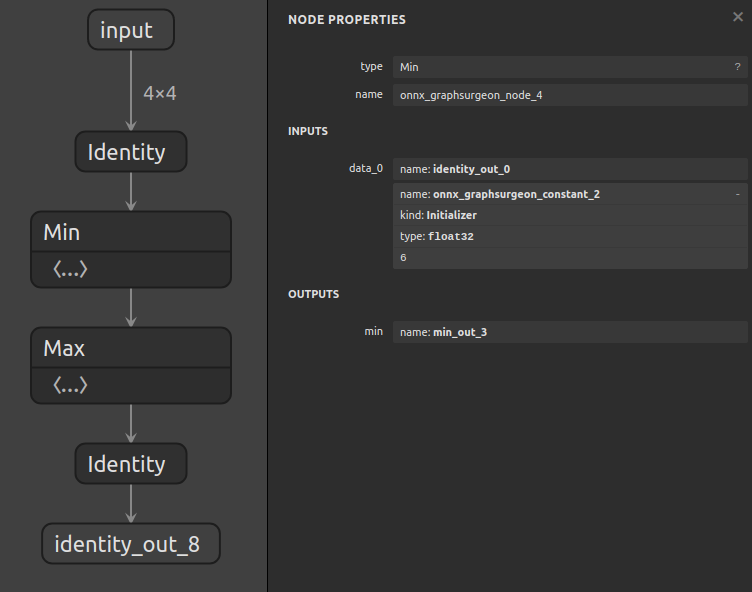


**Clipped Output:**


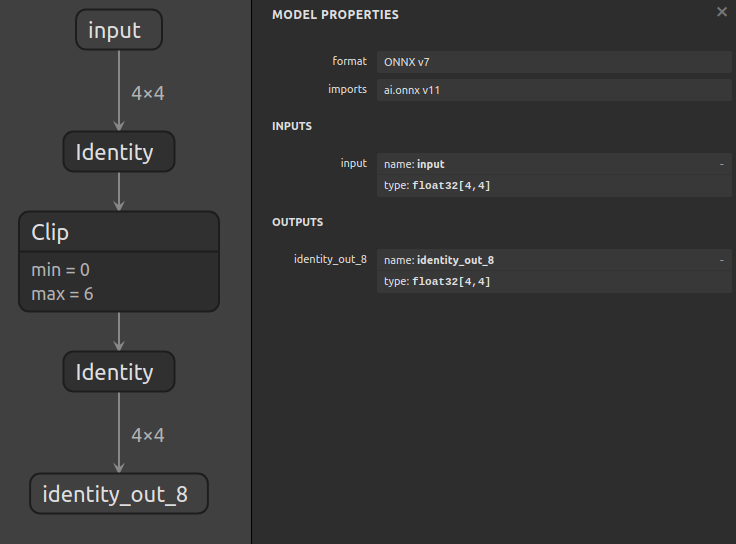

In [ ]:
# Initial Graph
@gs.Graph.register()
def min(self, *args):
    return self.layer(op="Min", inputs=args, outputs=["min_out"])[0]

@gs.Graph.register()
def max(self, *args):
    return self.layer(op="Max", inputs=args, outputs=["max_out"])[0]

@gs.Graph.register()
def identity(self, inp):
    return self.layer(op="Identity", inputs=[inp], outputs=["identity_out"])[0]


# Generate the graph
graph = gs.Graph()

graph.inputs = [gs.Variable("input", shape=(4, 4), dtype=np.float32)]

# Clip values to [0, 6]
MIN_VAL = np.array(0, np.float32)
MAX_VAL = np.array(6, np.float32)

# Add identity nodes to make the graph structure a bit more interesting
inp = graph.identity(graph.inputs[0])

"""
Min operation: Clips values above 6 → Min(inp, MAX_VAL).
Max operation: Clips values below 0 → Max(result, MIN_VAL).
Final effect: Clamps values between [0, 6].
"""
max_out = graph.max(graph.min(inp, MAX_VAL), MIN_VAL)

graph.outputs = [
    graph.identity(max_out),
]

# Graph outputs must include dtype information
graph.outputs[0].to_variable(dtype=np.float32, shape=(4, 4))

onnx.save(gs.export_onnx(graph), "model.onnx")
print("ONNX model 'model.onnx' generated successfully!")

ONNX model 'model.onnx' generated successfully!


In [ ]:
# Replacing min-max with clip

@gs.Graph.register()
def replace_with_clip(self, inputs, outputs):
    # Disconnect output nodes of all input tensors
    for inp in inputs:
        inp.outputs.clear()

    # Disconnet input nodes of all output tensors
    for out in outputs:
        out.inputs.clear()

    # Insert the new node.
    return self.layer(op="Clip", inputs=inputs, outputs=outputs)

graph = gs.import_onnx(onnx.load("model.onnx"))

tmap = graph.tensors()

for i in tmap:
    print(i)

# Inputs: [inp, MIN_VAL, MAX_VAL]
# Outputs: [max_out]

inputs = [
    tmap["identity_out_0"],
    tmap["onnx_graphsurgeon_constant_5"], # MIN_VALUE
    tmap["onnx_graphsurgeon_constant_2"], # MAX_VALUE
]
outputs = [tmap["max_out_6"]]

graph.replace_with_clip(inputs, outputs)
graph.cleanup().toposort()

onnx.save(gs.export_onnx(graph), "replaced.onnx")
print("\nONNX model 'replaced.onnx' generated successfully!")

input
identity_out_0
onnx_graphsurgeon_constant_2
min_out_3
onnx_graphsurgeon_constant_5
max_out_6
identity_out_8

ONNX model 'replaced.onnx' generated successfully!
